Use historical loan application data to predict whether or not an applicant will be able to repay a loan.
The label is a binary variable “TARGET”, indicating 0: the loan was repaid or 1: the loan was not repaid; indicating bad/good applicant.

The dataset contains applicants demographic information, financial status, and also some credit ratings from external sources.

The goal is to predict whether or not an applicant will repay the loan. 

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

#import necessary libraries here:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.decomposition import PCA
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.core import Dropout
from keras.callbacks import EarlyStopping
from keras.layers import BatchNormalization
from keras.initializers import Zeros, RandomNormal, he_normal

Using TensorFlow backend.


In [2]:
#load the dataset
data = pd.read_csv('application_train.csv')
df = data.copy()
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


### 1. Check the distribution of data points for each class label and  plot the histogram.

(array([282686.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  24825.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

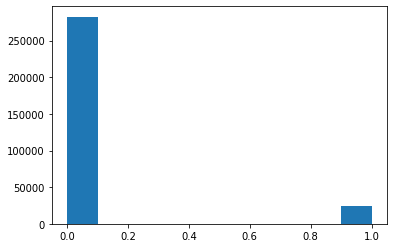

In [3]:
#write your code here
plt.hist(df['TARGET'])

### 2. Identify the number of features.

In [4]:
#write your code here
len(df.columns)

122

We have 121 features and 1 response variable 

In [5]:
#set index to SK_ID_CURR which is the customer ID
df = df.set_index('SK_ID_CURR')

In [6]:
#Explore outlier observations in the data.
df['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

In [7]:
df.ORGANIZATION_TYPE.unique()

array(['Business Entity Type 3', 'School', 'Government', 'Religion',
       'Other', 'XNA', 'Electricity', 'Medicine',
       'Business Entity Type 2', 'Self-employed', 'Transport: type 2',
       'Construction', 'Housing', 'Kindergarten', 'Trade: type 7',
       'Industry: type 11', 'Military', 'Services', 'Security Ministries',
       'Transport: type 4', 'Industry: type 1', 'Emergency', 'Security',
       'Trade: type 2', 'University', 'Transport: type 3', 'Police',
       'Business Entity Type 1', 'Postal', 'Industry: type 4',
       'Agriculture', 'Restaurant', 'Culture', 'Hotel',
       'Industry: type 7', 'Trade: type 3', 'Industry: type 3', 'Bank',
       'Industry: type 9', 'Insurance', 'Trade: type 6',
       'Industry: type 2', 'Transport: type 1', 'Industry: type 12',
       'Mobile', 'Trade: type 1', 'Industry: type 5', 'Industry: type 10',
       'Legal Services', 'Advertising', 'Trade: type 5', 'Cleaning',
       'Industry: type 13', 'Trade: type 4', 'Telecom',
       'I

In [8]:
df.CODE_GENDER.unique()

array(['M', 'F', 'XNA'], dtype=object)

### 3. How do you interprete the table above? What is the anomaly value for this attribute? plug in the anomaly value in the cell below '?' to replace it with NAN .

We notice that DAYS_EMPLOYED column has an anomaly value which is largely positive (365243) and CODE_GENDER & ORGANIZATION_TYPE have anomaly values of XNA

In [9]:
df.isnull().sum()

TARGET                             0
NAME_CONTRACT_TYPE                 0
CODE_GENDER                        0
FLAG_OWN_CAR                       0
FLAG_OWN_REALTY                    0
CNT_CHILDREN                       0
AMT_INCOME_TOTAL                   0
AMT_CREDIT                         0
AMT_ANNUITY                       12
AMT_GOODS_PRICE                  278
NAME_TYPE_SUITE                 1292
NAME_INCOME_TYPE                   0
NAME_EDUCATION_TYPE                0
NAME_FAMILY_STATUS                 0
NAME_HOUSING_TYPE                  0
REGION_POPULATION_RELATIVE         0
DAYS_BIRTH                         0
DAYS_EMPLOYED                      0
DAYS_REGISTRATION                  0
DAYS_ID_PUBLISH                    0
OWN_CAR_AGE                   202929
FLAG_MOBIL                         0
FLAG_EMP_PHONE                     0
FLAG_WORK_PHONE                    0
FLAG_CONT_MOBILE                   0
FLAG_PHONE                         0
FLAG_EMAIL                         0
O

In [10]:
#write your code here
df = df.replace(r'^\s+$', np.nan, regex=True) #replacing empty spaces with nan
df['DAYS_EMPLOYED']=df['DAYS_EMPLOYED'].replace(365243, np.nan)
df['ORGANIZATION_TYPE']=df['ORGANIZATION_TYPE'].replace('XNA', np.nan)
df['CODE_GENDER']=df['CODE_GENDER'].replace('XNA', np.nan)

In [11]:
#Convert the columns to float and the days columns to year. 
#We call the new columns as YEARS_BIRTH,... and remove the days columns.
df['DAYS_BIRTH'] = [float(-x//365)  for x in df.DAYS_BIRTH]
df['DAYS_EMPLOYED'] = [float(-x//365)  for x in df.DAYS_EMPLOYED]
df['DAYS_REGISTRATION'] = [float(-x//365)  for x in df.DAYS_REGISTRATION]
df['DAYS_ID_PUBLISH'] = [float(-x//365)  for x in df.DAYS_ID_PUBLISH]
df = df.rename(columns = {'DAYS_BIRTH': 'YEARS_BIRTH', 'DAYS_EMPLOYED': 'YEARS_EMPLOYED', 'DAYS_REGISTRATION': 'YEARS_REGISTRATION', 'DAYS_ID_PUBLISH': 'YEARS_ID_PUBLISH', })


### 4. Create bins of ['young adults', 'adults', 'seniors'] for YEARS_BIRTH with [19., 36., 53., 70.] border ages and remove YEARS_BIRTH column.

In [12]:
#write your code here
bins = [19, 36, 53, 70]
names = ['young adults', 'adults', 'seniors']
df['Age_Bins'] = pd.cut(df['YEARS_BIRTH'], bins, labels=names)

In [13]:
df.drop(["YEARS_BIRTH"], axis = 1, inplace = True)

### 5. Fill the missing values for our float variables with the median of the non-missing values for each feature


In [14]:
#write your code here
df=df.fillna(df.median())

In [15]:
#filling missing values of string variables with forward fill
df['NAME_TYPE_SUITE'].fillna(method = 'ffill',inplace=True)
df['OCCUPATION_TYPE'].fillna(method = 'ffill',inplace=True)
df['FONDKAPREMONT_MODE'].fillna(method = 'ffill',inplace=True)
df['HOUSETYPE_MODE'].fillna(method = 'ffill',inplace=True)
df['WALLSMATERIAL_MODE'].fillna(method = 'ffill',inplace=True)
df['EMERGENCYSTATE_MODE'].fillna(method = 'ffill',inplace=True)
df['CODE_GENDER'].fillna(method = 'ffill',inplace=True)
df['ORGANIZATION_TYPE'].fillna(method = 'ffill',inplace=True)

In [16]:
#checking for any leftover nan value in each column
df.isna().any()

TARGET                         False
NAME_CONTRACT_TYPE             False
CODE_GENDER                    False
FLAG_OWN_CAR                   False
FLAG_OWN_REALTY                False
CNT_CHILDREN                   False
AMT_INCOME_TOTAL               False
AMT_CREDIT                     False
AMT_ANNUITY                    False
AMT_GOODS_PRICE                False
NAME_TYPE_SUITE                False
NAME_INCOME_TYPE               False
NAME_EDUCATION_TYPE            False
NAME_FAMILY_STATUS             False
NAME_HOUSING_TYPE              False
REGION_POPULATION_RELATIVE     False
YEARS_EMPLOYED                 False
YEARS_REGISTRATION             False
YEARS_ID_PUBLISH               False
OWN_CAR_AGE                    False
FLAG_MOBIL                     False
FLAG_EMP_PHONE                 False
FLAG_WORK_PHONE                False
FLAG_CONT_MOBILE               False
FLAG_PHONE                     False
FLAG_EMAIL                     False
OCCUPATION_TYPE                False
C

### 6. Create dummy variables.

In [17]:
#write your code here: mapping dummy variable for each column with respective numbers (a messy way to do it)
mapping = {'N': 0, 'Y': 1}
df.replace({'FLAG_OWN_CAR': mapping})
mapping1 = {'Cash loans': 0, 'Revolving loans': 1}
df.replace({'FLAG_OWN_CAR': mapping}).replace({'NAME_CONTRACT_TYPE': mapping1})
mapping2 = {'M': 0, 'F': 1}
df.replace({'FLAG_OWN_CAR': mapping}).replace({'NAME_CONTRACT_TYPE': mapping1}).replace({'CODE_GENDER': mapping2})
mapping3 = {'Y': 1, 'N': 0}
df.replace({'FLAG_OWN_CAR': mapping}).replace({'NAME_CONTRACT_TYPE': mapping1}).replace({'CODE_GENDER': mapping2}).replace({'FLAG_OWN_REALTY': mapping3})
mapping4 = {'Children': 0, 'Family': 1, 'Group of people': 2, 'Other_A': 3, 'Other_B': 4, 'Spouse, partner': 5, 'Unaccompanied': 6}
df.replace({'FLAG_OWN_CAR': mapping}).replace({'NAME_CONTRACT_TYPE': mapping1}).replace({'CODE_GENDER': mapping2}).replace({'FLAG_OWN_REALTY': mapping3}).replace({'NAME_TYPE_SUITE': mapping4})
mapping5 = {'Businessman': 0, 'Commercial associate': 1, 'Maternity leave': 2, 'Pensioner': 3, 'State servant': 4, 'Student': 5, 'Unemployed': 6, 'Working': 7}
df.replace({'FLAG_OWN_CAR': mapping}).replace({'NAME_CONTRACT_TYPE': mapping1}).replace({'CODE_GENDER': mapping2}).replace({'FLAG_OWN_REALTY': mapping3}).replace({'NAME_TYPE_SUITE': mapping4}).replace({'NAME_INCOME_TYPE': mapping5})
mapping6 = {'Academic degree': 0, 'Higher education': 1, 'Incomplete higher': 2, 'Lower secondary': 3, 'Secondary / secondary special': 4}
df.replace({'FLAG_OWN_CAR': mapping}).replace({'NAME_CONTRACT_TYPE': mapping1}).replace({'CODE_GENDER': mapping2}).replace({'FLAG_OWN_REALTY': mapping3}).replace({'NAME_TYPE_SUITE': mapping4}).replace({'NAME_INCOME_TYPE': mapping5}).replace({'NAME_EDUCATION_TYPE': mapping6})
mapping7 = {'Civil marriage': 0, 'Married': 1, 'Separated': 2, 'Single / not married': 3, 'Unknown': 4, 'Widow': 5}
df.replace({'FLAG_OWN_CAR': mapping}).replace({'NAME_CONTRACT_TYPE': mapping1}).replace({'CODE_GENDER': mapping2}).replace({'FLAG_OWN_REALTY': mapping3}).replace({'NAME_TYPE_SUITE': mapping4}).replace({'NAME_INCOME_TYPE': mapping5}).replace({'NAME_EDUCATION_TYPE': mapping6}).replace({'NAME_FAMILY_STATUS': mapping7})
mapping8 = {'Co-op apartment': 0, 'House / apartment': 1, 'Municipal apartment': 2, 'Office apartment': 3, 'Rented apartment': 4, 'With parents': 5}
df.replace({'FLAG_OWN_CAR': mapping}).replace({'NAME_CONTRACT_TYPE': mapping1}).replace({'CODE_GENDER': mapping2}).replace({'FLAG_OWN_REALTY': mapping3}).replace({'NAME_TYPE_SUITE': mapping4}).replace({'NAME_INCOME_TYPE': mapping5}).replace({'NAME_EDUCATION_TYPE': mapping6}).replace({'NAME_FAMILY_STATUS': mapping7}).replace({'NAME_HOUSING_TYPE': mapping8})
mapping9 = {'Accountants': 0, 'Cleaning staff': 1, 'Cooking staff': 2, 'Core staff': 3, 'Drivers': 4, 'High skill tech staff': 5, 'HR staff': 6, 'IT staff': 7, 'Laborers': 8, 'Low-skill Laborers': 9, 'Managers': 10, 'Medicine staff': 11, 'Private service staff': 12, 'Realty agents': 13, 'Sales staff': 14, 'Secretaries': 15, 'Security staff': 16, 'Waiters/barmen staff': 17}
df.replace({'FLAG_OWN_CAR': mapping}).replace({'NAME_CONTRACT_TYPE': mapping1}).replace({'CODE_GENDER': mapping2}).replace({'FLAG_OWN_REALTY': mapping3}).replace({'NAME_TYPE_SUITE': mapping4}).replace({'NAME_INCOME_TYPE': mapping5}).replace({'NAME_EDUCATION_TYPE': mapping6}).replace({'NAME_FAMILY_STATUS': mapping7}).replace({'NAME_HOUSING_TYPE': mapping8}).replace({'OCCUPATION_TYPE': mapping9})
mapping10 = {'SUNDAY': 0, 'MONDAY': 1, 'TUESDAY': 2, 'WEDNESDAY': 3, 'THURSDAY': 4, 'FRIDAY': 5, 'SATURDAY': 6}
df.replace({'FLAG_OWN_CAR': mapping}).replace({'NAME_CONTRACT_TYPE': mapping1}).replace({'CODE_GENDER': mapping2}).replace({'FLAG_OWN_REALTY': mapping3}).replace({'NAME_TYPE_SUITE': mapping4}).replace({'NAME_INCOME_TYPE': mapping5}).replace({'NAME_EDUCATION_TYPE': mapping6}).replace({'NAME_FAMILY_STATUS': mapping7}).replace({'NAME_HOUSING_TYPE': mapping8}).replace({'OCCUPATION_TYPE': mapping9}).replace({'WEEKDAY_APPR_PROCESS_START': mapping10})
mapping11 = {'Advertising': 0, 'Agriculture': 1, 'Bank': 2, 'Business Entity Type 1': 3, 'Business Entity Type 2': 4, 'Business Entity Type 3': 5, 'Cleaning': 6, 'Construction': 7, 'Culture': 8, 'Electricity': 9, 'Emergency': 10, 'Government': 11, 'Hotel': 12, 'Housing': 13, 'Industry: type 1': 14, 'Industry: type 2': 15, 'Industry: type 3': 16, 'Industry: type 4': 17, 'Industry: type 5': 18, 'Industry: type 6': 19, 'Industry: type 7': 20, 'Industry: type 8': 21, 'Industry: type 9': 22, 'Industry: type 10': 23, 'Industry: type 11': 24, 'Industry: type 12': 25, 'Industry: type 13': 26, 'Insurance': 27, 'Kindergarten': 28, 'Legal Services': 29, 'Medicine': 30, 'Military': 31, 'Mobile': 32, 'Other': 33, 'Police': 34, 'Postal': 35, 'Realtor': 36, 'Religion': 37, 'Restaurant': 38, 'School': 39, 'Security': 40, 'Security Ministries': 41, 'Self-employed': 42, 'Services': 43, 'Telecom': 44, 'Trade: type 1': 45, 'Trade: type 2': 46, 'Trade: type 3': 47, 'Trade: type 4': 48, 'Trade: type 5': 49, 'Trade: type 6': 50, 'Trade: type 7': 51, 'Transport: type 1': 52, 'Transport: type 2': 53, 'Transport: type 3': 54, 'Transport: type 4': 55, 'University': 56}
df.replace({'FLAG_OWN_CAR': mapping}).replace({'NAME_CONTRACT_TYPE': mapping1}).replace({'CODE_GENDER': mapping2}).replace({'FLAG_OWN_REALTY': mapping3}).replace({'NAME_TYPE_SUITE': mapping4}).replace({'NAME_INCOME_TYPE': mapping5}).replace({'NAME_EDUCATION_TYPE': mapping6}).replace({'NAME_FAMILY_STATUS': mapping7}).replace({'NAME_HOUSING_TYPE': mapping8}).replace({'OCCUPATION_TYPE': mapping9}).replace({'WEEKDAY_APPR_PROCESS_START': mapping10}).replace({'ORGANIZATION_TYPE': mapping11})
mapping12 = {'not specified': 0, 'org spec account': 1, 'reg oper account': 2, 'reg oper spec account': 3}
df.replace({'FLAG_OWN_CAR': mapping}).replace({'NAME_CONTRACT_TYPE': mapping1}).replace({'CODE_GENDER': mapping2}).replace({'FLAG_OWN_REALTY': mapping3}).replace({'NAME_TYPE_SUITE': mapping4}).replace({'NAME_INCOME_TYPE': mapping5}).replace({'NAME_EDUCATION_TYPE': mapping6}).replace({'NAME_FAMILY_STATUS': mapping7}).replace({'NAME_HOUSING_TYPE': mapping8}).replace({'OCCUPATION_TYPE': mapping9}).replace({'WEEKDAY_APPR_PROCESS_START': mapping10}).replace({'ORGANIZATION_TYPE': mapping11}).replace({'FONDKAPREMONT_MODE': mapping12})
mapping13 = {'block of flats': 0, 'terraced house': 1, 'specific housing': 2}
df.replace({'FLAG_OWN_CAR': mapping}).replace({'NAME_CONTRACT_TYPE': mapping1}).replace({'CODE_GENDER': mapping2}).replace({'FLAG_OWN_REALTY': mapping3}).replace({'NAME_TYPE_SUITE': mapping4}).replace({'NAME_INCOME_TYPE': mapping5}).replace({'NAME_EDUCATION_TYPE': mapping6}).replace({'NAME_FAMILY_STATUS': mapping7}).replace({'NAME_HOUSING_TYPE': mapping8}).replace({'OCCUPATION_TYPE': mapping9}).replace({'WEEKDAY_APPR_PROCESS_START': mapping10}).replace({'ORGANIZATION_TYPE': mapping11}).replace({'FONDKAPREMONT_MODE': mapping12}).replace({'HOUSETYPE_MODE': mapping13})
mapping14 = {'Block': 0, 'Mixed': 1, 'Monolithic': 2, 'Others': 3, 'Panel': 4, 'Stone, brick': 5, 'Wooden': 6}
df.replace({'FLAG_OWN_CAR': mapping}).replace({'NAME_CONTRACT_TYPE': mapping1}).replace({'CODE_GENDER': mapping2}).replace({'FLAG_OWN_REALTY': mapping3}).replace({'NAME_TYPE_SUITE': mapping4}).replace({'NAME_INCOME_TYPE': mapping5}).replace({'NAME_EDUCATION_TYPE': mapping6}).replace({'NAME_FAMILY_STATUS': mapping7}).replace({'NAME_HOUSING_TYPE': mapping8}).replace({'OCCUPATION_TYPE': mapping9}).replace({'WEEKDAY_APPR_PROCESS_START': mapping10}).replace({'ORGANIZATION_TYPE': mapping11}).replace({'FONDKAPREMONT_MODE': mapping12}).replace({'HOUSETYPE_MODE': mapping13}).replace({'WALLSMATERIAL_MODE': mapping14})
mapping15 = {'No': 0, 'Yes': 1}
df.replace({'FLAG_OWN_CAR': mapping}).replace({'NAME_CONTRACT_TYPE': mapping1}).replace({'CODE_GENDER': mapping2}).replace({'FLAG_OWN_REALTY': mapping3}).replace({'NAME_TYPE_SUITE': mapping4}).replace({'NAME_INCOME_TYPE': mapping5}).replace({'NAME_EDUCATION_TYPE': mapping6}).replace({'NAME_FAMILY_STATUS': mapping7}).replace({'NAME_HOUSING_TYPE': mapping8}).replace({'OCCUPATION_TYPE': mapping9}).replace({'WEEKDAY_APPR_PROCESS_START': mapping10}).replace({'ORGANIZATION_TYPE': mapping11}).replace({'FONDKAPREMONT_MODE': mapping12}).replace({'HOUSETYPE_MODE': mapping13}).replace({'WALLSMATERIAL_MODE': mapping14}).replace({'EMERGENCYSTATE_MODE': mapping15})
mapping16 = {'young adults': 0, 'adults': 1, 'seniors': 2}
df.replace({'FLAG_OWN_CAR': mapping}).replace({'NAME_CONTRACT_TYPE': mapping1}).replace({'CODE_GENDER': mapping2}).replace({'FLAG_OWN_REALTY': mapping3}).replace({'NAME_TYPE_SUITE': mapping4}).replace({'NAME_INCOME_TYPE': mapping5}).replace({'NAME_EDUCATION_TYPE': mapping6}).replace({'NAME_FAMILY_STATUS': mapping7}).replace({'NAME_HOUSING_TYPE': mapping8}).replace({'OCCUPATION_TYPE': mapping9}).replace({'WEEKDAY_APPR_PROCESS_START': mapping10}).replace({'ORGANIZATION_TYPE': mapping11}).replace({'FONDKAPREMONT_MODE': mapping12}).replace({'HOUSETYPE_MODE': mapping13}).replace({'WALLSMATERIAL_MODE': mapping14}).replace({'EMERGENCYSTATE_MODE': mapping15}).replace({'Age_Bins': mapping16})

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,Age_Bins
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,1,0,0,0,1,0,202500.000,406597.5,24700.5,351000.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0
100003,0,0,1,0,0,0,270000.000,1293502.5,35698.5,1129500.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1
100004,0,1,0,1,1,0,67500.000,135000.0,6750.0,135000.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1
100006,0,0,1,0,1,0,135000.000,312682.5,29686.5,297000.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1
100007,0,0,0,0,1,0,121500.000,513000.0,21865.5,513000.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2
100008,0,0,0,0,1,0,99000.000,490495.5,27517.5,454500.0,...,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0,1
100009,0,0,1,1,1,1,171000.000,1560726.0,41301.0,1395000.0,...,0,0,0,0.0,0.0,0.0,1.0,1.0,2.0,1
100010,0,0,0,1,1,0,360000.000,1530000.0,42075.0,1530000.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1
100011,0,0,1,0,1,0,112500.000,1019610.0,33826.5,913500.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,2


### 7. Standardize the columns to be in the range of (0,1).

In [18]:
#write your code here
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df.replace({'FLAG_OWN_CAR': mapping}).replace({'NAME_CONTRACT_TYPE': mapping1}).replace({'CODE_GENDER': mapping2}).replace({'FLAG_OWN_REALTY': mapping3}).replace({'NAME_TYPE_SUITE': mapping4}).replace({'NAME_INCOME_TYPE': mapping5}).replace({'NAME_EDUCATION_TYPE': mapping6}).replace({'NAME_FAMILY_STATUS': mapping7}).replace({'NAME_HOUSING_TYPE': mapping8}).replace({'OCCUPATION_TYPE': mapping9}).replace({'WEEKDAY_APPR_PROCESS_START': mapping10}).replace({'ORGANIZATION_TYPE': mapping11}).replace({'FONDKAPREMONT_MODE': mapping12}).replace({'HOUSETYPE_MODE': mapping13}).replace({'WALLSMATERIAL_MODE': mapping14}).replace({'EMERGENCYSTATE_MODE': mapping15}).replace({'Age_Bins': mapping16}))

In [19]:
new_df = pd.DataFrame(df_scaled, columns=df.columns, index=df.index)

In [20]:
X = new_df.drop('TARGET', axis = 1)
Y = new_df['TARGET']

### 8. Split training testing dataset using X and Y created in the cell above and split with the test size of 20% and randomstate=12345 and call them X_train, Y_train, X_test, and Y_test.

In [21]:
#write your code here
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=12345)

### 9. Fit a decision tree classifier and explain your choice of hyperparameters. Tune two of the hyperparameters for 3 different values and print the test score for each scenario (total 6 scenarios).

In [22]:
#write your code here
clf = tree.DecisionTreeClassifier(criterion='gini', min_samples_split=2, max_depth=None)
clf = clf.fit(X_train, Y_train)
score = clf.score(X_test, Y_test)
print(score)

0.8503975415833374


In [23]:
max_depth_range = [15, 20, 25]
features_range = ['auto', 'sqrt', 'log2']
accuracy = []
for depth in max_depth_range:
    print('Tree Depth:', depth)
    cla = DecisionTreeClassifier(max_depth = depth)
    cla.fit(X_train, Y_train)
    score = cla.score(X_test, Y_test)
    print('Accuracy:', score)
    accuracy.append(score)
for features in features_range:
    print('The number of features to consider when looking for the best split:', features)
    cla = DecisionTreeClassifier(max_features = features)
    cla.fit(X_train, Y_train)
    score = cla.score(X_test, Y_test)
    print('Accuracy:', score)
    accuracy.append(score)

Tree Depth: 15
Accuracy: 0.9072565565907355
Tree Depth: 20
Accuracy: 0.8909484090206982
Tree Depth: 25
Accuracy: 0.8741687397362731
The number of features to consider when looking for the best split: auto
Accuracy: 0.8526413345690455
The number of features to consider when looking for the best split: sqrt
Accuracy: 0.8535193405199747
The number of features to consider when looking for the best split: log2
Accuracy: 0.8567549550428435


### 10. Fit a Randomforest classifier with alpha = [200,500,1000,2000] and max_depth = [7, 10] and print the 5fold cross validation score. 

In [24]:
#write your code here
alpha_range = [200, 500, 1000, 2000]
max_depth_range = [7, 10]
accuracy = []
cv_scores_list=[]
for alpha in alpha_range:
    print('Alpha:', alpha)
    clf = RandomForestClassifier(min_samples_split = alpha) 
    clf.fit(X_train, Y_train)
    score = clf.score(X_test, Y_test)
    print('Accuracy:', score)
    accuracy.append(score)
    cv_scores = cross_val_score(clf, X, Y,cv=5)
    cv_scores_list.append(np.mean(cv_scores))
    print('Cross-validation scores (5-fold):', cv_scores)
    print('Mean cross-validation score (5-fold): {:.3f}'.format(np.mean(cv_scores)))
for depth in max_depth_range:
    print('Depth:', depth)
    clf = RandomForestClassifier(max_depth = depth) 
    clf.fit(X_train, Y_train)
    score = clf.score(X_test, Y_test)
    print('Accuracy:', score)
    accuracy.append(score)
    cv_scores = cross_val_score(clf, X, Y,cv=5)
    cv_scores_list.append(np.mean(cv_scores))
    print('Cross-validation scores (5-fold):', cv_scores)
    print('Mean cross-validation score (5-fold): {:.3f}'.format(np.mean(cv_scores)))

Alpha: 200
Accuracy: 0.9204754239630587
Cross-validation scores (5-fold): [0.91928849 0.91925466 0.91927092 0.91927092 0.91925466]
Mean cross-validation score (5-fold): 0.919
Alpha: 500
Accuracy: 0.9204754239630587
Cross-validation scores (5-fold): [0.91927223 0.91927092 0.91927092 0.91927092 0.91927092]
Mean cross-validation score (5-fold): 0.919
Alpha: 1000
Accuracy: 0.9204591645935971
Cross-validation scores (5-fold): [0.91927223 0.91927092 0.91927092 0.91927092 0.91927092]
Mean cross-validation score (5-fold): 0.919
Alpha: 2000
Accuracy: 0.9204591645935971
Cross-validation scores (5-fold): [0.91927223 0.91927092 0.91927092 0.91927092 0.91927092]
Mean cross-validation score (5-fold): 0.919
Depth: 7
Accuracy: 0.9204591645935971
Cross-validation scores (5-fold): [0.91927223 0.91927092 0.91927092 0.91927092 0.91927092]
Mean cross-validation score (5-fold): 0.919
Depth: 10
Accuracy: 0.9204429052241354
Cross-validation scores (5-fold): [0.91927223 0.91925466 0.91927092 0.91928718 0.91927

### 11. Identify the importance of each variables and list the first 15 important variables.

In [25]:
#write your code here
clf = RandomForestClassifier() 
clf.fit(X_train, Y_train)
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(clf.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False)
importances.head(15)

,feature,importance
39,EXT_SOURCE_2,0.058
40,EXT_SOURCE_3,0.053
7,AMT_ANNUITY,0.035
92,DAYS_LAST_PHONE_CHANGE,0.033
6,AMT_CREDIT,0.032
38,EXT_SOURCE_1,0.030
5,AMT_INCOME_TOTAL,0.030
16,YEARS_REGISTRATION,0.029
8,AMT_GOODS_PRICE,0.029
14,REGION_POPULATION_RELATIVE,0.027


### 13. Applying a principle component analysis and generating the scree plot for explained variance ratio to decide about the best number of components. Compare it with the initial number of variables.

In [26]:
#write your code here
pcamodel = PCA(n_components=121)
pca = pcamodel.fit_transform(new_df)

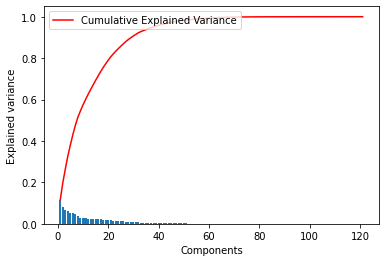

In [27]:
plt.bar(range(1,len(pcamodel.explained_variance_ratio_ )+1),pcamodel.explained_variance_ratio_ )
plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.plot(range(1,len(pcamodel.explained_variance_ratio_ )+1),
         np.cumsum(pcamodel.explained_variance_ratio_),
         c='red',
         label="Cumulative Explained Variance")
plt.legend(loc='upper left')

We observe from the scree plot that the cumulative explained variance is over 95% for the whole dataset with the help of around 45 Principle Components. Hence, we can use these 45 PC instead of the whole 120 features for predicting the output label.

### 14. Fit a neural network without regularization.

In [28]:
#write your code here

#Define the model:
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

#Compile the model:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

#Fit the model:
model.fit(X_train, Y_train, batch_size=32, epochs=3)

#Evaluate the model:
test_loss, test_acc = model.evaluate(X_test,  Y_test, verbose=2)
print('\nTest loss:', test_loss)
print('\nTest accuracy:', test_acc)

Epoch 1/3
246008/246008 [==============================] - 10s 42us/step - loss: 0.2603 - accuracy: 0.9189
Epoch 2/3
246008/246008 [==============================] - 9s 37us/step - loss: 0.2591 - accuracy: 0.9190
Epoch 3/3
246008/246008 [==============================] - 8s 33us/step - loss: 0.2596 - accuracy: 0.9190

Test loss: 0.2572383412668911

Test accuracy: 0.9204428791999817


### 15. Activation function (Advantages and disadvantages of the selected activation function)

ReLu: Advantages are that it provides uniform gradient and does not saturate even for large values which is helpful for hidden layers. Disadvatanges are that it remains zero for negative units and does not update the model for that interval.

Sigmoid: Advatange of using sigmoid for output layer in our model is that our model has binary output and sigmoid function does a good job in predicting binary outputs with input values close to zero. Disadvatnge of using sigmoid function is that it saturates for high positive and negative values and does not help in updating the model

### 16. Cost function.

Binary Crossentropy: Since we two have two class labels, i.e. 0 & 1, we can easily predict the difference between true value and predicted value for the two classes of output label using this Cost Function  

### 17. 3 different optimization approach. Discuss the difference in the performance of the training.

In [29]:
#write your code here
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

#Fit the model:
model.fit(X_train, Y_train, epochs=3)

#Evaluate the model:
train_loss, train_acc = model.evaluate(X_train,  Y_train, verbose=2)
print('\nTrain loss:', train_loss)
print('\nTrain accuracy:', train_acc)

Epoch 1/3
246008/246008 [==============================] - 8s 33us/step - loss: 0.2592 - accuracy: 0.9190
Epoch 2/3
246008/246008 [==============================] - 9s 37us/step - loss: 0.2592 - accuracy: 0.9190
Epoch 3/3
246008/246008 [==============================] - 11s 44us/step - loss: 0.2594 - accuracy: 0.9188

Train loss: 0.2584488498850964

Train accuracy: 0.9188928604125977


In [30]:
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

#Fit the model:
model.fit(X_train, Y_train, epochs=3)

#Evaluate the model:
train_loss, train_acc = model.evaluate(X_train,  Y_train, verbose=2)
print('\nTrain loss:', train_loss)
print('\nTrain accuracy:', train_acc)

Epoch 1/3
246008/246008 [==============================] - 11s 44us/step - loss: 0.2561 - accuracy: 0.91890s - loss: 0.2
Epoch 2/3
246008/246008 [==============================] - 9s 35us/step - loss: 0.2537 - accuracy: 0.9189
Epoch 3/3
246008/246008 [==============================] - 9s 35us/step - loss: 0.2530 - accuracy: 0.9190

Train loss: 0.25200978420404163

Train accuracy: 0.9189782738685608


In [31]:
model.compile(optimizer='Adagrad', loss='binary_crossentropy', metrics=['accuracy'])

#Fit the model:
model.fit(X_train, Y_train, epochs=3)

#Evaluate the model:
train_loss, train_acc = model.evaluate(X_train,  Y_train, verbose=2)
print('\nTrain loss:', train_loss)
print('\nTrain accuracy:', train_acc)

Epoch 1/3
246008/246008 [==============================] - 8s 34us/step - loss: 0.2520 - accuracy: 0.9189 1s - loss: 0.2517 - accuracy -
Epoch 2/3
246008/246008 [==============================] - 8s 32us/step - loss: 0.2517 - accuracy: 0.9189
Epoch 3/3
246008/246008 [==============================] - 8s 33us/step - loss: 0.2516 - accuracy: 0.9190

Train loss: 0.2514707161003561

Train accuracy: 0.9190229773521423


I used RMSProp, Adam and Adagrad optimizer for evaluation of the network. Although the three optimizers had similiar performance of training in terms of accuracy, but when we notice the performance of training in terms of loss function, we notice that Adagrad optimizer had slightly better performance 

### 18. Evaluate a Deeper Network Topology

In [32]:
#write your code here
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

#Compile the model:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

#Fit the model:
model.fit(X_train, Y_train, batch_size=32, epochs=3)

#Evaluate the model:
test_loss, test_acc = model.evaluate(X_test,  Y_test, verbose=2)
print('\nTest loss:', test_loss)
print('\nTest accuracy:', test_acc)

Epoch 1/3
246008/246008 [==============================] - 10s 40us/step - loss: 0.2622 - accuracy: 0.91890s - loss: 0.2622 - accuracy: 0.91
Epoch 2/3
246008/246008 [==============================] - 11s 45us/step - loss: 0.2608 - accuracy: 0.9190
Epoch 3/3
246008/246008 [==============================] - 11s 43us/step - loss: 0.2609 - accuracy: 0.9190

Test loss: 0.25611133869949565

Test accuracy: 0.9203616380691528


### 19. Evaluate a Wider Network Topology


In [33]:
#write your code here
#Define the model:
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

#Compile the model:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

#Fit the model:
model.fit(X_train, Y_train, batch_size=32, epochs=3)

#Evaluate the model:
test_loss, test_acc = model.evaluate(X_test,  Y_test, verbose=2)
print('\nTest loss:', test_loss)
print('\nTest accuracy:', test_acc)

Epoch 1/3
246008/246008 [==============================] - 12s 50us/step - loss: 0.2613 - accuracy: 0.9189
Epoch 2/3
246008/246008 [==============================] - 11s 43us/step - loss: 0.2601 - accuracy: 0.9190
Epoch 3/3
246008/246008 [==============================] - 10s 40us/step - loss: 0.2594 - accuracy: 0.9190

Test loss: 0.25886095982042695

Test accuracy: 0.9204591512680054


Deep and Wide neural netwroks had same performance in terms of accuracy, but wider neural network performed better in terms of test loss. 

The best architecture so far for this dataset has been a network with Adagrad optimizer (on training data) and a wider network structure rather than deeper network structure as it helps in improving the model's test loss (although very small improvement from deep network). Sigmoid activation function does a good job at the output layer of the network.

### 20. The best architecture so far.
### Implement 3 different initialization methods: zero initialization, large random initialization and He initialization. For the same number of iterations and same hyperparameters compare the performance of the model and explain the advantage of each.

In [34]:
#write your code here
#Define the model:
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu', kernel_initializer='RandomNormal'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

#Compile the model:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

#Fit the model:
model.fit(X_train, Y_train, batch_size=32, epochs=3)

#Evaluate the model:
test_loss, test_acc = model.evaluate(X_test,  Y_test, verbose=2)
print('\nTest loss:', test_loss)
print('\nTest accuracy:', test_acc)

Epoch 1/3
246008/246008 [==============================] - 10s 39us/step - loss: 0.2613 - accuracy: 0.9190
Epoch 2/3
246008/246008 [==============================] - 10s 39us/step - loss: 0.2600 - accuracy: 0.91900s - loss: 0.2602 - accuracy - ETA: 0s - l
Epoch 3/3
246008/246008 [==============================] - 9s 38us/step - loss: 0.2600 - accuracy: 0.9190

Test loss: 0.2561011502467068

Test accuracy: 0.9204591512680054


In [35]:
#Define the model:
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu', kernel_initializer='Zeros'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

#Compile the model:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

#Fit the model:
model.fit(X_train, Y_train, batch_size=32, epochs=3)

#Evaluate the model:
test_loss, test_acc = model.evaluate(X_test,  Y_test, verbose=2)
print('\nTest loss:', test_loss)
print('\nTest accuracy:', test_acc)

Epoch 1/3
246008/246008 [==============================] - 11s 43us/step - loss: 0.3199 - accuracy: 0.9190
Epoch 2/3
246008/246008 [==============================] - 10s 39us/step - loss: 0.2813 - accuracy: 0.9190
Epoch 3/3
246008/246008 [==============================] - 10s 40us/step - loss: 0.2813 - accuracy: 0.9190

Test loss: 0.2776478744715347

Test accuracy: 0.9204591512680054


In [36]:
#Define the model:
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu', kernel_initializer='he_normal'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

#Compile the model:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

#Fit the model:
model.fit(X_train, Y_train, batch_size=32, epochs=3)

#Evaluate the model:
test_loss, test_acc = model.evaluate(X_test,  Y_test, verbose=2)
print('\nTest loss:', test_loss)
print('\nTest accuracy:', test_acc)

Epoch 1/3
246008/246008 [==============================] - 10s 41us/step - loss: 0.2610 - accuracy: 0.9189
Epoch 2/3
246008/246008 [==============================] - 10s 40us/step - loss: 0.2598 - accuracy: 0.9190
Epoch 3/3
246008/246008 [==============================] - 10s 40us/step - loss: 0.2591 - accuracy: 0.9190

Test loss: 0.25823744676678057

Test accuracy: 0.9204591512680054


Among the three initialization functions for the network, the 'he_normal' and 'random' initialization function perform equally well for this dataset while 'zero' initialization function performs slightly poorly than the other two. The 'random large' acts as a good initialzation function as it works towards breaking the symmetry of the input values and helps in faster convergence of the model. In 'he_normal' initialization, each layers' weight is randomly initiailized with prior attention to the weights of the previous layers which helps in attaining convergence at a much faster than usual rate. 'Zero' initialization initializes the network in such a way that all the weights along with biases in initial layer and subsequent layers are zero. There is no update in these weights in the backpropagation and following iterations and they remain constant throughout the network. This initializer is advantageous if we need same value of weights throughout the network without any update in the iterations.

### 21. Batch normalization 

In [37]:
#write your code here
#Define the model:
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

#Compile the model:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

#Fit the model:
model.fit(X_train, Y_train, batch_size=32, epochs=3)

#Evaluate the model:
test_loss, test_acc = model.evaluate(X_test,  Y_test, verbose=2)
print('\nTest loss:', test_loss)
print('\nTest accuracy:', test_acc)

Epoch 1/3
246008/246008 [==============================] - 12s 47us/step - loss: 0.2658 - accuracy: 0.9162
Epoch 2/3
246008/246008 [==============================] - 11s 46us/step - loss: 0.2575 - accuracy: 0.9189
Epoch 3/3
246008/246008 [==============================] - 11s 46us/step - loss: 0.2568 - accuracy: 0.9189

Test loss: 0.2550514998878752

Test accuracy: 0.9204916954040527


Batch normalization is used to solve the covariate shift of the paramters of the previous layer while updating the present layer as while updating the current layer, it is thought that the previous layers' paramters remain constant which is not the case in neural networks. Batch normalization makes the model unaffected by this constant change in previous layers. By doing so, we make the optimization and hence convergence uniform and also reduces the dependence on initialization

### 22. Regularization  

In [38]:
#write your code here
#Define the model:
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

#Compile the model:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

#Fit the model:
model.fit(X_train, Y_train, batch_size=32, epochs=3)

#Evaluate the model:
train_loss, train_acc = model.evaluate(X_train,  Y_train, verbose=2)
print('\nTrain loss:', train_loss)
print('\nTrain accuracy:', train_acc)
test_loss, test_acc = model.evaluate(X_test,  Y_test, verbose=2)
print('\nTest loss:', test_loss)
print('\nTest accuracy:', test_acc)

Epoch 1/3
246008/246008 [==============================] - 9s 36us/step - loss: 0.2744 - accuracy: 0.9190 0s - loss: 0.2747 - ac
Epoch 2/3
246008/246008 [==============================] - 9s 36us/step - loss: 0.2630 - accuracy: 0.9190 0s -
Epoch 3/3
246008/246008 [==============================] - 9s 36us/step - loss: 0.2622 - accuracy: 0.9190

Train loss: 0.26269891672314893

Train accuracy: 0.9189741611480713

Test loss: 0.2594866470776133

Test accuracy: 0.9204591512680054


Regularization hurts our model's training accuracy slightly as it reduces the value of many features which were not significant close to zero (l2 norm). This reduction in training set performance is mainly due to the fact that the reduced value of features, although results in loss of information and hence the accuracy of training of the dataset, it is compensated overall by the increase in generalization of the model over unseen dataset. 

### 23. Dropout during training.

In [39]:
#write your code here
#Define the model:
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

#Compile the model:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

#Fit the model:
model.fit(X_train, Y_train, batch_size=32, epochs=3)

#Evaluate the model:
test_loss, test_acc = model.evaluate(X_test,  Y_test, verbose=2)
print('\nTest loss:', test_loss)
print('\nTest accuracy:', test_acc)

Epoch 1/3
246008/246008 [==============================] - 10s 40us/step - loss: 0.2708 - accuracy: 0.9190
Epoch 2/3
246008/246008 [==============================] - 11s 44us/step - loss: 0.2685 - accuracy: 0.9190
Epoch 3/3
246008/246008 [==============================] - 10s 41us/step - loss: 0.2694 - accuracy: 0.9190

Test loss: 0.2665282834523628

Test accuracy: 0.9204591512680054


When we perform dropout for the network, dropping 20% of the connections in the first layer and keeping 80% while dropping 50% of the connections in the second layer, we notice that test accuracy is almost the same but the test loss increases by a marginal amount. Despite these drawbacks, dropout is a good option to apply in our dataset as it increases the generalization of the model over an unseen dataset by including different connections and networks in the neaural net architecture.

### 24. Creating an svm Classifier and our choice of kernel. Use a 10-fold cross validation to evaluate how well your model performs. Report precision and recall.

In [ ]:
#write your code here
clf = svm.SVC(kernel='linear') # Linear Kernel: still takes too long to run
clf.fit(X_train, Y_train)

In [ ]:
cv_scores = cross_val_score(clf, X, Y,cv=10)
cv_scores_list.append(np.mean(cv_scores))
print('Cross-validation scores (10-fold):', cv_scores)
print('Mean cross-validation score (10-fold): {:.3f}'.format(np.mean(cv_scores)))

In [ ]:
test_pred=clf.predict(X_test)
print(classification_report(Y_test, test_pred))

### 25. Discussions

When we perform PCA for the dataset, we find that more than 95% of the variance of the dataset is explained by the 45 principle components. Hence, we can greatly reduce the computation cost and time for model developement and evaluation by considering just these 45 PC's instead of the whole 121 dataset features. 
Further, when we compare all the models, we find that neural network does the best job for this dataset because of its extensive network architecture and greater generalization ability. Hence, we choose the neural network model to predict whether the loan will be repaid by the customer or not, indicating a potential good/bad applicant.